# Setting up the AlexNet Model on CIFAR100

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alexnet-cifar100/pytorch/default/1/alexnet_cifar100.pth


In [9]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Number of training samples: 50000
Number of test samples: 10000
Classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',

In [10]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data preprocessing and augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(224),  # Resize CIFAR-100 images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-100 dataset
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, transform=transform_test, download=True)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

# Load pretrained AlexNet and modify it for CIFAR-100
model = torchvision.models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(4096, 100)  # Change the output layer to match CIFAR-100 classes
model = model.to(device)

# Freeze feature extractor layers
for param in model.features.parameters():
    param.requires_grad = False

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            tepoch.set_postfix(loss=(running_loss / (tepoch.n + 1)))

    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs} completed. Loss: {running_loss / len(train_loader):.4f}")

print("Training completed!")

# Evaluation loop
model.eval()
correct = 0
total = 0

with tqdm(test_loader, unit="batch", desc="Evaluating") as teval:
    with torch.no_grad():
        for inputs, labels in teval:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update tqdm with accuracy
            teval.set_postfix(accuracy=(100 * correct / total))

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Using device: cuda


100%|██████████| 169001437/169001437 [00:03<00:00, 55659479.95it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 168MB/s]  
Epoch 1/30:   0%|          | 56/50000 [00:02<32:53, 25.31batch/s, loss=5.14]  


KeyboardInterrupt: 

In [5]:
# Save the trained model
model_path = "alexnet_cifar100.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to alexnet_cifar100.pth


In [ ]:
# Validation Loop
model.eval()
val_loss = 0.0
correct1 = 0
correct5 = 0
total = 0

with torch.no_grad():
    with tqdm(test_loader, desc=f"Validation", unit="batch") as teval:
        for inputs, labels in teval:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            # Compute Top-1 and Top-5 predictions
            _, pred1 = outputs.topk(1, 1, True, True)  # Top-1
            _, pred5 = outputs.topk(5, 1, True, True)  # Top-5

            # Calculate correct predictions
            correct1 += pred1.eq(labels.view(-1, 1).expand_as(pred1)).sum().item()
            correct5 += pred5.eq(labels.view(-1, 1).expand_as(pred5)).sum().item()
            total += labels.size(0)

            # Update tqdm with current metrics
            teval.set_postfix(
                val_loss=val_loss / total,
                top1_acc=(100 * correct1 / total),
                top5_acc=(100 * correct5 / total),
            )

# Final validation metrics
epoch_val_loss = val_loss / len(test_loader.dataset)
top1_acc = correct1 / total
top5_acc = correct5 / total

print(f"Validation Loss: {epoch_val_loss:.4f}")
print(f"Top-1 Accuracy: {top1_acc * 100:.2f}%, Top-5 Accuracy: {top5_acc * 100:.2f}%")


# Adversarial Attacks

In [5]:
# Load the model
model_path = ("/kaggle/input/alexnet-cifar100/pytorch/default/1/alexnet_cifar100.pth")
model = torchvision.models.alexnet(pretrained=False)  # Initialize AlexNet
model.classifier[6] = nn.Linear(4096, 100)  # Adjust for CIFAR-100
model.load_state_dict(torch.load(model_path))  # Load the saved state dictionary
print(device)
model = model.to(device)  # Send the model to the appropriate device
print("Model loaded successfully!")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_30/116166712.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend

cuda
Model loaded successfully!


In [4]:
!pip install torchattacks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 2.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.


## FGSM Attacks: 

In [6]:
import torchattacks

# FGSM Attack
fgsm = torchattacks.FGSM(model, eps=0.3)  # epsilon defines the perturbation strength
adv_examples_fgsm = []

# Apply FGSM attack
model.eval()
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    # Generate adversarial examples
    adv_inputs = fgsm(inputs, labels)

    # Store adversarial examples
    adv_examples_fgsm.append((adv_inputs, labels))

# Check performance on adversarial examples
correct_top1 = 0
total = 0
for adv_inputs, labels in adv_examples_fgsm:
    outputs = model(adv_inputs)
    _, predictions = outputs.max(1)
    correct_top1 += (predictions == labels).sum().item()
    total += labels.size(0)

print(f"FGSM Top-1 Accuracy: {100 * correct_top1 / total:.2f}%")

FGSM Top-1 Accuracy: 3.09%


## PGD Attacks

Evaluating Adversarial Examples: 100%|██████████| 10000/10000 [00:16<00:00, 611.55it/s]


PGD Top-1 Accuracy: 0.00%


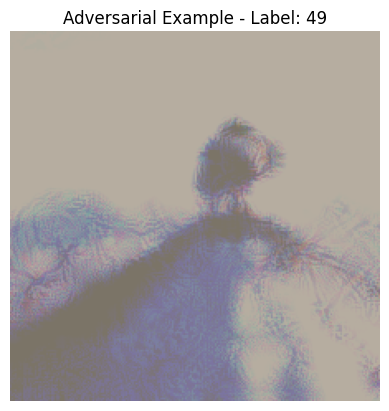

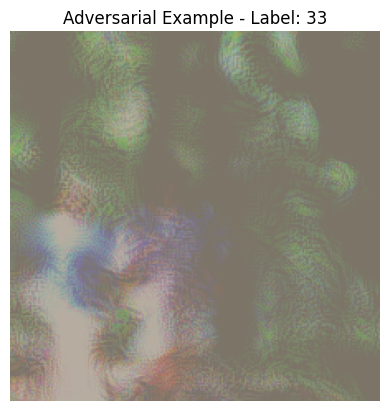

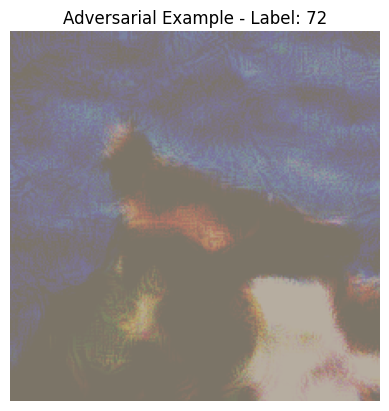

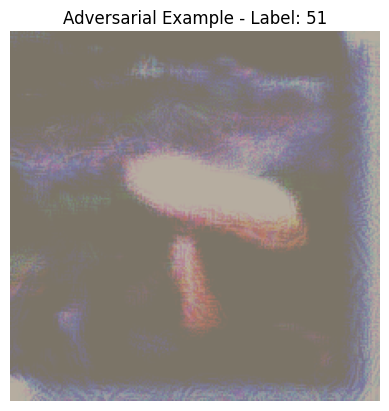

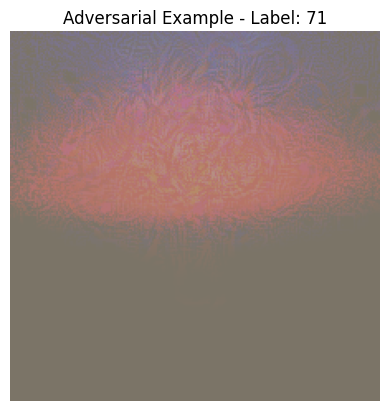

In [5]:
from tqdm import tqdm
import torchattacks
import matplotlib.pyplot as plt
import torchvision.transforms as T

# PGD Attack
pgd = torchattacks.PGD(model, eps=0.3, alpha=2/255, steps=40)  # eps is the maximum perturbation

adv_examples_pgd = []

# Apply PGD attack with tqdm progress bar
model.eval()
for inputs, labels in tqdm(test_loader, desc="Generating Adversarial Examples"):
    inputs, labels = inputs.to(device), labels.to(device)

    # Generate adversarial examples
    adv_inputs = pgd(inputs, labels)

    # Store adversarial examples
    adv_examples_pgd.append((adv_inputs, labels))

# Check performance on adversarial examples with tqdm progress bar
correct_top1 = 0
total = 0
for adv_inputs, labels in tqdm(adv_examples_pgd, desc="Evaluating Adversarial Examples"):
    outputs = model(adv_inputs)
    _, predictions = outputs.max(1)
    correct_top1 += (predictions == labels).sum().item()
    total += labels.size(0)

print(f"PGD Top-1 Accuracy: {100 * correct_top1 / total:.2f}%")

# Visualization of Adversarial Examples
# Function to unnormalize and display an image
def show_image(tensor, title):
    unnormalize = T.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )  # Reverse ImageNet normalization
    tensor = unnormalize(tensor).clamp(0, 1)  # Ensure values are in range [0, 1]
    image = tensor.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display a few adversarial examples
for i, (adv_inputs, labels) in enumerate(adv_examples_pgd):
    if i == 5:  # Show only the first 5 batches
        break
    for j in range(min(5, adv_inputs.size(0))):  # Show up to 5 images per batch
        show_image(adv_inputs[j], f"Adversarial Example - Label: {labels[j].item()}")


## CW Attacks

In [7]:
from tqdm import tqdm

# Initialize the CW attack
cw = torchattacks.CW(model, c=1e-4, kappa=0, steps=100, lr=0.01)  # c and kappa control the attack intensity

adv_examples_cw = []

# Apply CW attack
model.eval()
print("Generating adversarial examples...")
for inputs, labels in tqdm(test_loader, desc="CW Attack Progress"):
    inputs, labels = inputs.to(device), labels.to(device)

    # Generate adversarial examples
    adv_inputs = cw(inputs, labels)

    # Store adversarial examples
    adv_examples_cw.append((adv_inputs, labels))

# Check performance on adversarial examples
correct_top1 = 0
total = 0
print("Evaluating adversarial examples...")
for adv_inputs, labels in tqdm(adv_examples_cw, desc="Evaluation Progress"):
    outputs = model(adv_inputs)
    _, predictions = outputs.max(1)
    correct_top1 += (predictions == labels).sum().item()
    total += labels.size(0)

print(f"CW Top-1 Accuracy: {100 * correct_top1 / total:.2f}%")

# Measure perturbation magnitude
print("Calculating perturbation magnitude...")
for inputs, labels in tqdm(test_loader, desc="Perturbation Analysis", total=1):  # Process one batch
    inputs, labels = inputs.to(device), labels.to(device)

    # Generate adversarial examples with CW
    adv_inputs = cw(inputs, labels)

    # Calculate perturbation
    perturbation = (adv_inputs - inputs).abs()
    max_perturbation = perturbation.max().item()

    print(f"Max CW Perturbation: {max_perturbation}")
    break  # Check on one batch for simplicity

Generating adversarial examples...


CW Attack Progress: 100%|██████████| 10000/10000 [1:17:41<00:00,  2.15it/s]


Evaluating adversarial examples...


Evaluation Progress: 100%|██████████| 10000/10000 [00:16<00:00, 614.92it/s]


CW Top-1 Accuracy: 13.26%
Calculating perturbation magnitude...


Perturbation Analysis:   0%|          | 0/1 [00:01<?, ?it/s]

Max CW Perturbation: 1.6400001049041748
